In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import AutoImageProcessor, ResNetForImageClassification,ResNetConfig
import torch
from abc import ABC,abstractmethod

c:\Users\assaw\.conda\envs\AI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#TODO check if layers are actually being trained
#TODO add more models
#TODO compare metrics
#TODO test out prediction loop
#TODO learn how to use tensorboard

#TODO day2 Balance Dataset
#TODO day2 Implement checkpointing and checkpoint loading
#TODO day2 implement an actually good and modular pipeline
#TODO day2 EDA + explore augments
#TODO day2 normalize and test out mean/median/std of pixel values
#TODO day2 Actually implement additional layers and finish what i started
#TODO Verify data is sent correctly (esp labels)

#TODO day2 implement localization + research more abt osteopenia

###DATASET PREP###

In [4]:
projectPath = r"Osteoporosis Knee X-ray"
pathList = []
labelList = []
dirList = os.listdir(projectPath)[:3]
for idx, x in enumerate(dirList):
    for xx in os.listdir(f"{projectPath}/{x}"):
        pathList.append(f"{projectPath}/{x}/{xx}")
        labelList.append(idx)

In [5]:
from PIL import Image
imageSizes = {}
for x in pathList:
    img = Image.open(x).size
    try:
        imageSizes[str(img)] = imageSizes[str(img)] + 1
    except KeyError:
        imageSizes[str(img)] = 1
imageSizes #varied image sizes, have to resize to 1024,1024

{'(1024, 1024)': 63,
 '(2180, 2660)': 61,
 '(2660, 2180)': 10,
 '(2430, 1994)': 94,
 '(2386, 1994)': 1,
 '(1994, 2430)': 2,
 '(2430, 1910)': 2,
 '(2402, 1994)': 1,
 '(2378, 1994)': 2,
 '(2362, 1994)': 1,
 '(2430, 1958)': 1,
 '(2398, 1994)': 1}

In [55]:
labelList.count(0),labelList.count(1),labelList.count(2)

(36, 154, 49)

In [6]:
import torchvision
import torch


class OsteoTorchDataset(torch.utils.data.Dataset):
    def __init__(self, itemsPath:list, labels:list, transform=None):
        
        self.itemsPath = itemsPath
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.itemsPath)

    def __getitem__(self,idx)->tuple[Image.Image,int]:
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()
        image = Image.open(self.itemsPath[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return torchvision.transforms.functional.pil_to_tensor(image), self.labels[idx]
        
    

transform = torchvision.transforms.Compose([torchvision.transforms.Resize([244,244])
                                            # ,torchvision.transforms.Grayscale()
                                            ])
osteoDataset = OsteoTorchDataset(pathList,labelList,transform)
                                            

In [64]:
from torch.utils.data.dataloader import DataLoader

train,val = torch.utils.data.random_split(osteoDataset,[0.7,0.3])#MAY BUG

trainLoader = DataLoader(train, batch_size = 16,shuffle=False,num_workers=0)
valLoader = DataLoader(val, batch_size = 16,shuffle=False,num_workers=0)

In [8]:
# from dataWrapper import DataWrapper
# BUG still dosent work, does not fix the Num_workers issue
# loader = DataWrapper(pathList,labelList, batch_size = 16,shuffle=False,num_workers=15)

In [66]:
len(valL)

5

In [9]:
# import models here
from models import AlexNet

In [59]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model

Using cache found in C:\Users\assaw/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\assaw\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\assaw\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [52]:
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from torcheval.metrics.functional import multiclass_f1_score,multiclass_confusion_matrix,multiclass_accuracy
from torchmetrics.classification import MulticlassConfusionMatrix
from matplotlib import pyplot as plt
from torch import mode
import torch.nn.functional as F
import itertools
import seaborn as sns

#FIXME implement proper instancing to support multiple models
#FIXME identify bottleneck
#FIXME clean up my fucking code ffs its so UGLY
#FIXME 

class ExperimentModel(L.LightningModule):
    def __init__(self,pretrainedModel,pretrainedPreprocess,outputSize,resize = False) -> None:
        super().__init__()
        self.model = pretrainedModel
        # if pretrainedPreprocess:
        #     self.preprocess = pretrainedPreprocess  
        # for param in self.model.parameters():
        #     param.requires_grad = False
        self.resize = resize
        if self.resize:
            self.linear1 = torch.nn.Linear(outputSize, 512)
            self.linear2 = torch.nn.Linear(512, 32)
            self.linear3 = torch.nn.Linear(32, 3) 
        self.valLog = []
        self.epoch = []
        self.valPreds = []
        self.valLabels = []
        
    def forward(self,input):
        out = self.model(input)
        if self.resize:
            out = self.linear1(out)
            out = self.linear2(out)
            out = self.linear3(out)
        return out

        
    def training_step(self,batch):
        data,label = batch
        output = self(data.float())
        loss= F.cross_entropy(output,label)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        data,label = batch
        output = self(data.float())
        loss= F.cross_entropy(output,label)
        self.valLabels.append(label)
        self.valPreds.append(output)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc_F1", multiclass_f1_score(output,label,num_classes=3), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", multiclass_accuracy(output,label,num_classes=3), on_step=False, on_epoch=True, prog_bar=True, logger=True)

    # def predict(self)
    def on_test_epoch_end(self) -> None:
        # self.log("cust",self.linear3.weight.sum(),logger=True)

        y_hat = torch.cat(self.valPreds)
        y = torch.cat(self.valLabels)

        confusion_matrix = MulticlassConfusionMatrix(num_classes=3, threshold=0.05)
        confusion_matrix(y_hat, y.int())

        confusion_matrix_computed = confusion_matrix.compute().detach().cpu().numpy().astype(int)

        df_cm = pd.DataFrame(confusion_matrix_computed)
        plt.figure(figsize = (10,7))
        fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
        plt.close(fig_)
        self.log.experiment.add_figure("Confusion matrix", fig_, self.current_epoch)

    def get_self_variables(self):
        linear_variables = [x for x in dir(self) if 'linear' in x]
        return [getattr(self, x, None).parameters() for x in linear_variables]
        

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(),lr=0.001)
        # return torch.optim.AdamW(itertools.chain(self.model.parameters(),*self.get_self_variables()), lr=0.001)
        pass

    def predict_step(self, batch):
        data,label = batch
        return self(data.float())

# class ResNetCallbacks(L.Callback): #TODO implement callbacks
#     def on_validation_epoch_end(trainer, pl_module):
#         valLog.append(sum(self.cumLog)/len(self.cumlog))

    
# alexNet = ExperimentModel(AlexNet(num_classes=1000),None,1000,True)
# alexNetNonMod = ExperimentModel(AlexNet(num_classes=3),None,3)
alexNetNonMod = ExperimentModel(model,None,1000,True)

In [53]:
import gc
gc.collect()
torch.cuda.empty_cache()

from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    verbose=True,        # Verbosity mode
    mode='min'           # Mode can be 'min', 'max', or 'auto'
)

logger = TensorBoardLogger("tb_logs", name="my_model")

trainer = L.Trainer(max_epochs = 7,accelerator='gpu', devices='auto', precision='16-mixed',callbacks=[early_stopping],logger=logger)
# trainer.fit(model=alexNet,train_dataloaders=loader.trainLoader,val_dataloaders=loader.valLoader)
trainer.fit(model=alexNetNonMod,train_dataloaders=trainLoader,val_dataloaders=valLoader)

Epoch 1:  45%|████▌     | 5/11 [02:37<03:08,  0.03it/s, v_num=8, train_loss_step=3.320, val_loss=1.250, val_acc_F1=0.592, val_acc=0.592, train_loss_epoch=2.340]


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | model   | ResNet | 25.6 M | train
1 | linear1 | Linear | 512 K  | train
2 | linear2 | Linear | 16.4 K | train
3 | linear3 | Linear | 99     | train
-------------------------------------------
26.1 M    Trainable params
0         Non-trainable params
26.1 M    Total params
104.344   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s, v_num=10, train_loss_step=2.010, val_loss=73.60, val_acc_F1=0.620, val_acc=0.620, train_loss_epoch=3.160]

Metric val_loss improved. New best score: 73.561


Epoch 1: 100%|██████████| 11/11 [00:09<00:00,  1.10it/s, v_num=10, train_loss_step=0.932, val_loss=2.350, val_acc_F1=0.620, val_acc=0.620, train_loss_epoch=1.440]

Metric val_loss improved by 71.207 >= min_delta = 0.0. New best score: 2.354


Epoch 2: 100%|██████████| 11/11 [00:09<00:00,  1.17it/s, v_num=10, train_loss_step=1.070, val_loss=1.690, val_acc_F1=0.380, val_acc=0.380, train_loss_epoch=1.150]

Metric val_loss improved by 0.666 >= min_delta = 0.0. New best score: 1.689


Epoch 3: 100%|██████████| 11/11 [00:09<00:00,  1.17it/s, v_num=10, train_loss_step=0.756, val_loss=1.090, val_acc_F1=0.620, val_acc=0.620, train_loss_epoch=0.948]

Metric val_loss improved by 0.598 >= min_delta = 0.0. New best score: 1.090


Epoch 5: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s, v_num=10, train_loss_step=0.891, val_loss=1.020, val_acc_F1=0.620, val_acc=0.620, train_loss_epoch=0.972]

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 1.021


Epoch 6: 100%|██████████| 11/11 [00:09<00:00,  1.12it/s, v_num=10, train_loss_step=0.764, val_loss=0.957, val_acc_F1=0.620, val_acc=0.620, train_loss_epoch=0.951]

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 0.957
`Trainer.fit` stopped: `max_epochs=7` reached.


Epoch 6: 100%|██████████| 11/11 [00:11<00:00,  0.99it/s, v_num=10, train_loss_step=0.764, val_loss=0.957, val_acc_F1=0.620, val_acc=0.620, train_loss_epoch=0.951]


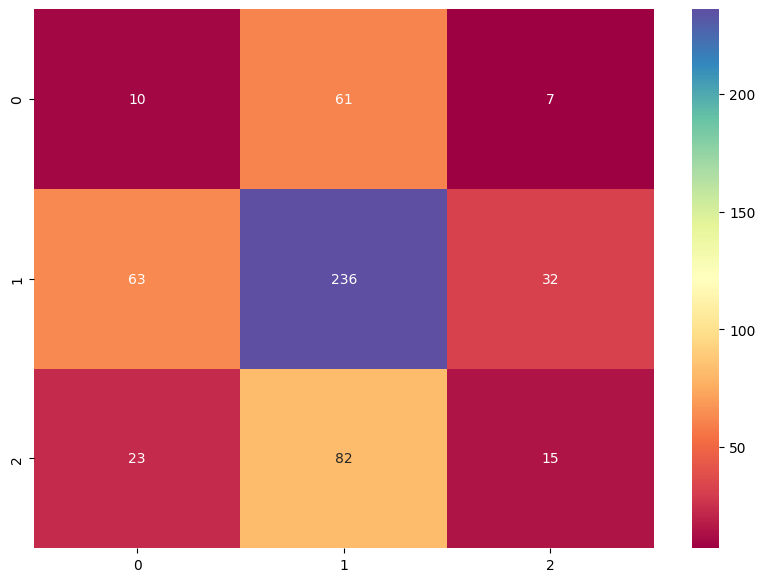

In [56]:
# raise AssertionError("Stop here")
# alex net acc F1 = 0.62 loss = 0.923
# resnet18 acc F1 = ? loss = 1
# resnet50 acc F1 = 0.29 loss = 3
# resnet50 Custom acc F1 = 0.62 loss = 0.957


# model = alexNetNonMod.load_from_checkpoint("/path/to/checkpoint.ckpt")


def testConfMatrix(self) -> None:
        # self.log("cust",self.linear3.weight.sum(),logger=True)

        y_hat = torch.cat(self.valPreds)
        y = torch.cat(self.valLabels)

        confusion_matrix = MulticlassConfusionMatrix(num_classes=3).to('cuda')
        confusion_matrix(y_hat, y.int())

        confusion_matrix_computed = confusion_matrix.compute().detach().cpu().numpy().astype(int)

        df_cm = pd.DataFrame(confusion_matrix_computed)
        plt.figure(figsize = (10,7))
        fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral',fmt='g').get_figure()
        plt.show()
       

testConfMatrix(alexNetNonMod)

# early_stopping = EarlyStopping(
#     monitor='val_loss',  # Metric to monitor
#     patience=3,          # Number of epochs with no improvement after which training will be stopped
#     verbose=True,        # Verbosity mode
#     mode='min'           # Mode can be 'min', 'max', or 'auto'
# )

# logger = TensorBoardLogger("tb_logs", name="my_model")
# trainer = L.Trainer(max_epochs = 20,accelerator='gpu', devices='auto', precision='16-mixed',callbacks=[early_stopping],logger=logger)
# trainer.fit(model=alexNetNonMod,train_dataloaders=trainLoader,val_dataloaders=valLoader)

In [25]:
# !kill 27636
%reload_ext tensorboard
%tensorboard --logdir=tb_logs/

'kill' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
data = []
label = []
valOutput = []
valLabel = []

from itertools import tee
testTrainer =  L.Trainer(accelerator='gpu', devices='auto')
out = testTrainer.predict(alexNet, valLoader)

loader1, loader2 = tee(valLoader)#BUG BUG BUG INCREDIBLY MEMORY INEFFICIENT DONOT RUN THIS ON ANYTHIGN BIGGER THAN 1000 IMAGES

for idx,x in enumerate(valLoader):
    data,label = x
    [valLabel.append(x) for x in label]

valOutput = trainer.predict(alexNet, loader2)

In [ ]:
label